# 3D Camera Projection (World Position -> Pixel Position)

**Note:** This example requires `ropy.ignition` and [`gym-ignition`](https://github.com/robotology/gym-ignition).

---

In this example, we will walk through the process of performing a 3D projection. Given a scene
and a camera looking at the scene, a 3D projection takes the location of an object (in 3d space) and
maps it onto a corresponding location on the camera sensor (2d space, pixels).

This is useful if you, for example, have a robot with a camera that performs some kind of object detection.
When evaluating the detection algorithm in simulation, a 3D projection allows you to compute the ground truth
of where the object should be detected.

Another useful application of 3D projections is to visualize trajectories by, for example, tracking the position
of a robot's end-effector in world space, projecting it onto a camera, and then visualizing the path the end-effector
took.

## Setup

This example makes use of Ignition Gazebo, meaning that we will simulate a world to obtain the camera image. You can find the required world file (and the full code of this example) in this gist:

https://gist.github.com/FirefoxMetzger/dc9af8ae62fce176a3fe037d095988dc#file-world1-sdf

You will need the second file called `world1.sdf`, which has to be saved next to this notebook.



## Initialize the Simulator and get a Camera Image

In [1]:
from scenario import gazebo as scenario_gazebo
import ropy.ignition as ign
import numpy as np

def camera_parser(msg):
    image_msg = ign.messages.Image()
    image_msg.parse(msg[2])

    image = np.frombuffer(image_msg.data, dtype=np.uint8)
    image = image.reshape((image_msg.height, image_msg.width, 3))

    return image

gazebo = scenario_gazebo.GazeboSimulator(step_size=0.001, rtf=1.0, steps_per_run=1)
assert gazebo.insert_world_from_sdf("./camera_test.sdf")
gazebo.initialize()

gazebo.run(paused=True)

# reference to the objects in the scene
camera = gazebo.get_world("camera_sensor").get_model("camera").get_link("link")
box = gazebo.get_world("camera_sensor").get_model("box")

# get the camera image for later visualization
with ign.Subscriber("/camera", parser=camera_parser) as camera_topic:
    gazebo.run(paused=True)
    img = camera_topic.recv()

## Compute the Intrinsic and Extrinsic Camera matrices

This is the meat of the process. To project a point from world-space into image-space we first have to express the object in the camera's coordinate system (in the camera-space); the matrix that represents this transformation is typically called the extrinsic matrix. Then, we have to project the point from camera-space into image-space mapping world coordinates to pixels; the matrix representing this projection is typically called the intrinsic matrix and it's parameters are called the intrinsic camera parameters.

To compute the extrinsic matrix we can leverage `ropy.transform.coordinates` which comes with a handy array of functions to transform between coordinate systems.

To compute the intrinsic matrix we can leverage `ropy.transform.projections` which contains a function to compute a projection matrix for a perspective camera using a frustum-based projection, i.e., by specifying the camera's field of view and resolution. A format that is very commonly used by simulators and game engines.

In [2]:
import ropy.transform as tf
from scipy.spatial.transform import Rotation as R


# get extrinsic matrix
cam_pos_world = np.array(camera.position())
cam_ori_world_quat = np.array(camera.orientation())[[1, 2, 3, 0]]
cam_ori_world = R.from_quat(cam_ori_world_quat).as_euler("xyz")
camera_frame_world = np.stack((cam_pos_world, cam_ori_world)).ravel()
extrinsic_transform = tf.coordinates.transform(camera_frame_world)

# get intrinsic matrix (parameters known a-priori from world1.sdf)
width = 320
height = 240
hFoV = 1.047
intrinsic_transform = tf.projections.camera_frustum(hFoV, (height, width))

Now we can apply the projection to the corner of the box

In [3]:
box_corner = np.array(box.base_position()) + np.array((0.5, -0.5, 0.5))
pos_world = tf.homogenize(box_corner)
pos_cam = np.matmul(extrinsic_transform, pos_world)
pos_px_hom = np.matmul(intrinsic_transform, pos_cam)
cube_pos_px = tf.cartesianize(pos_px_hom)

and visualize the result

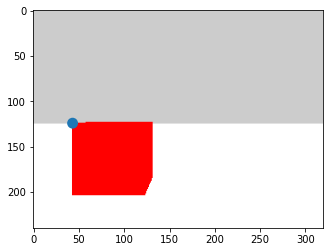

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

fig, ax = plt.subplots(1)
ax.imshow(img)
ax.add_patch(Circle(cube_pos_px, radius=6))
plt.show()

Don't forget to close the simulator in the end.

In [5]:
gazebo.close()


True